# Tuorial 5, Question 3

In [1]:
import torch
from torch import nn

import numpy as np
import matplotlib.pyplot as plt

In [2]:
no_labels = 1
no_features = 2
no_exps = 10

lr = 0.05
no_epochs = 5000
patience = 10

hidden_units = [2, 4, 6, 8, 10]

In [3]:
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

In [4]:
class MLP(nn.Module):
    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            nn.Linear(no_features, no_hidden),
            nn.Sigmoid(),
            nn.Linear(no_hidden, no_labels),
        )

    def forward(self, x):
        logits = self.mlp_stack(x)
        return logits

In [5]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [6]:
# perform experiments
def train_exp(X, Y):

    x_test, y_test = X[:34], Y[:34]
    x_train, y_train = X[34:77], Y[34:77]
    x_valid, y_valid = X[77:], Y[77:]

    err = []
    for no_hidden in hidden_units:

        model = MLP(no_features, no_hidden, no_labels)
    
        loss_fn = torch.nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        early_stopper = EarlyStopper(patience=patience, min_delta=0)
        
        for epoch in range(no_epochs):
            pred = model(torch.tensor(x_train, dtype=torch.float))
            train_loss = loss_fn(pred, torch.tensor(y_train, dtype=torch.float))
    
            # Backpropagation
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
        
            pred = model(torch.tensor(x_valid, dtype=torch.float))
            valid_loss = loss_fn(pred, torch.tensor(y_valid, dtype=torch.float))
            
            if early_stopper.early_stop(valid_loss): 
                break
                    
        err.append(valid_loss.item())
    
    no_hidden = hidden_units[np.argmin(err)]       
    x_train, y_train = X[34:], Y[34:]
    
    model = MLP(no_features, no_hidden, no_labels)
    
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    early_stopper = EarlyStopper(patience=patience, min_delta=0)
        
    for epoch in range(no_epochs):
        pred = model(torch.tensor(x_train, dtype=torch.float))
        train_loss = loss_fn(pred, torch.tensor(y_train, dtype=torch.float))
    
        # Backpropagation
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        pred = model(torch.tensor(x_test, dtype=torch.float))
        test_loss = loss_fn(pred, torch.tensor(y_test, dtype=torch.float))
            
        if early_stopper.early_stop(test_loss): 
            break
        
    return no_hidden, test_loss.item()
    

In [7]:
# generate training data
X = np.zeros((10*10, 2))
no_data = 0
for i in np.arange(-1.0, 1.001, 2.0/9.0):
    for j in np.arange(-1.0, 1.001, 2.0/9.0):
        X[no_data] = [i, j]
        no_data += 1
Y = np.zeros((no_data, 1))
Y[:,0] = np.sin(np.pi*X[:,0])*np.cos(2*np.pi*X[:,1])

In [8]:
idx = np.arange(no_data)

# perform experiments
no_hidden, err = [], []

print('hidden units: {}'.format(hidden_units))
for exp in range(no_exps):
 
    np.random.shuffle(idx)
    no_hidden_, err_ = train_exp(X[idx], Y[idx])
        
    no_hidden.append(no_hidden_)
    err.append(err_)
    print('exp %d, hidden units %d, error %g'%(exp, no_hidden[exp], err[exp]))


hidden units: [2, 4, 6, 8, 10]
exp 0, hidden units 8, error 0.21515
exp 1, hidden units 8, error 0.30891
exp 2, hidden units 2, error 0.290746
exp 3, hidden units 6, error 0.25048
exp 4, hidden units 2, error 0.24168
exp 5, hidden units 2, error 0.271474
exp 6, hidden units 4, error 0.332684
exp 7, hidden units 2, error 0.244129
exp 8, hidden units 4, error 0.293861
exp 9, hidden units 4, error 0.226081


In [9]:
# find the consensus of experiments
hidden_counts = np.zeros(len(hidden_units)).astype(int)
for exp in range(no_exps):
    hidden_counts[no_hidden[exp]//2-1] += 1

print(hidden_counts)
opt_hidden = hidden_units[np.argmax(hidden_counts)]
print('* %d *'%opt_hidden)

print('error = %g'%np.mean(err[no_hidden == opt_hidden]))

[4 3 1 2 0]
* 2 *
error = 0.21515


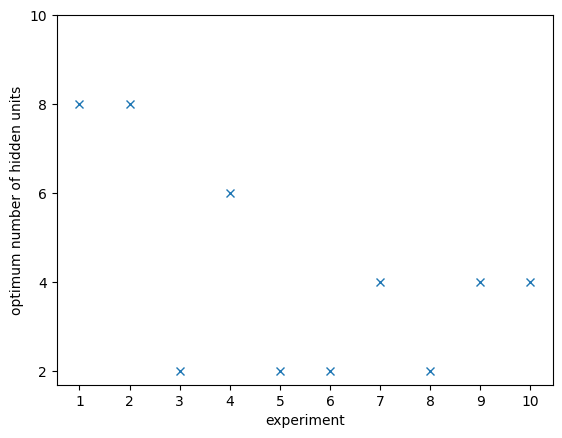

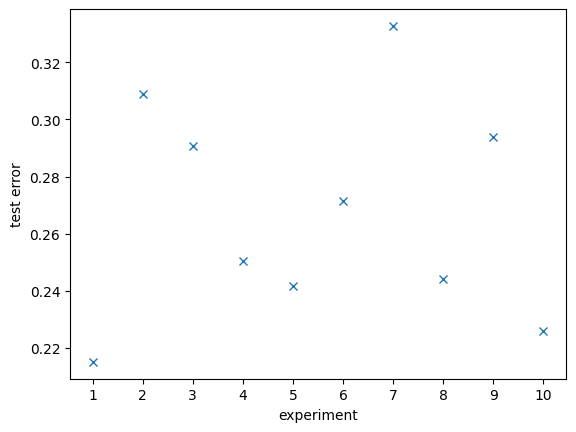

In [10]:
# plot the results
plt.figure(1)
plt.plot(range(no_exps), no_hidden, marker = 'x', linestyle = 'None')
plt.yticks(hidden_units)
plt.xticks(range(no_exps), np.arange(no_exps)+1)
plt.xlabel('experiment')
plt.ylabel('optimum number of hidden units')
plt.show()

plt.figure(2)
plt.plot(range(no_exps), err, marker = 'x', linestyle = 'None')
plt.xticks(range(no_exps), np.arange(no_exps)+1)
plt.xlabel('experiment')
plt.ylabel('test error')
plt.show()